In [54]:
import numpy as np
import pandas as pd
import shap

import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score

In [5]:
df = pd.read_csv('customer_churn.csv')

df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [6]:
df.info()
df.drop(columns=['customerID'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


<h3 style="text-align: center; font-family: 'Times New Roman'"> Data analysis and preprocessing </h3>

In [7]:
sns.set_style('darkgrid')

PALETTE = "Set2"
sns.set_palette(PALETTE)
sns.color_palette(PALETTE)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [9]:
numerical_columns = df.select_dtypes(include=['int64', 'float64'])

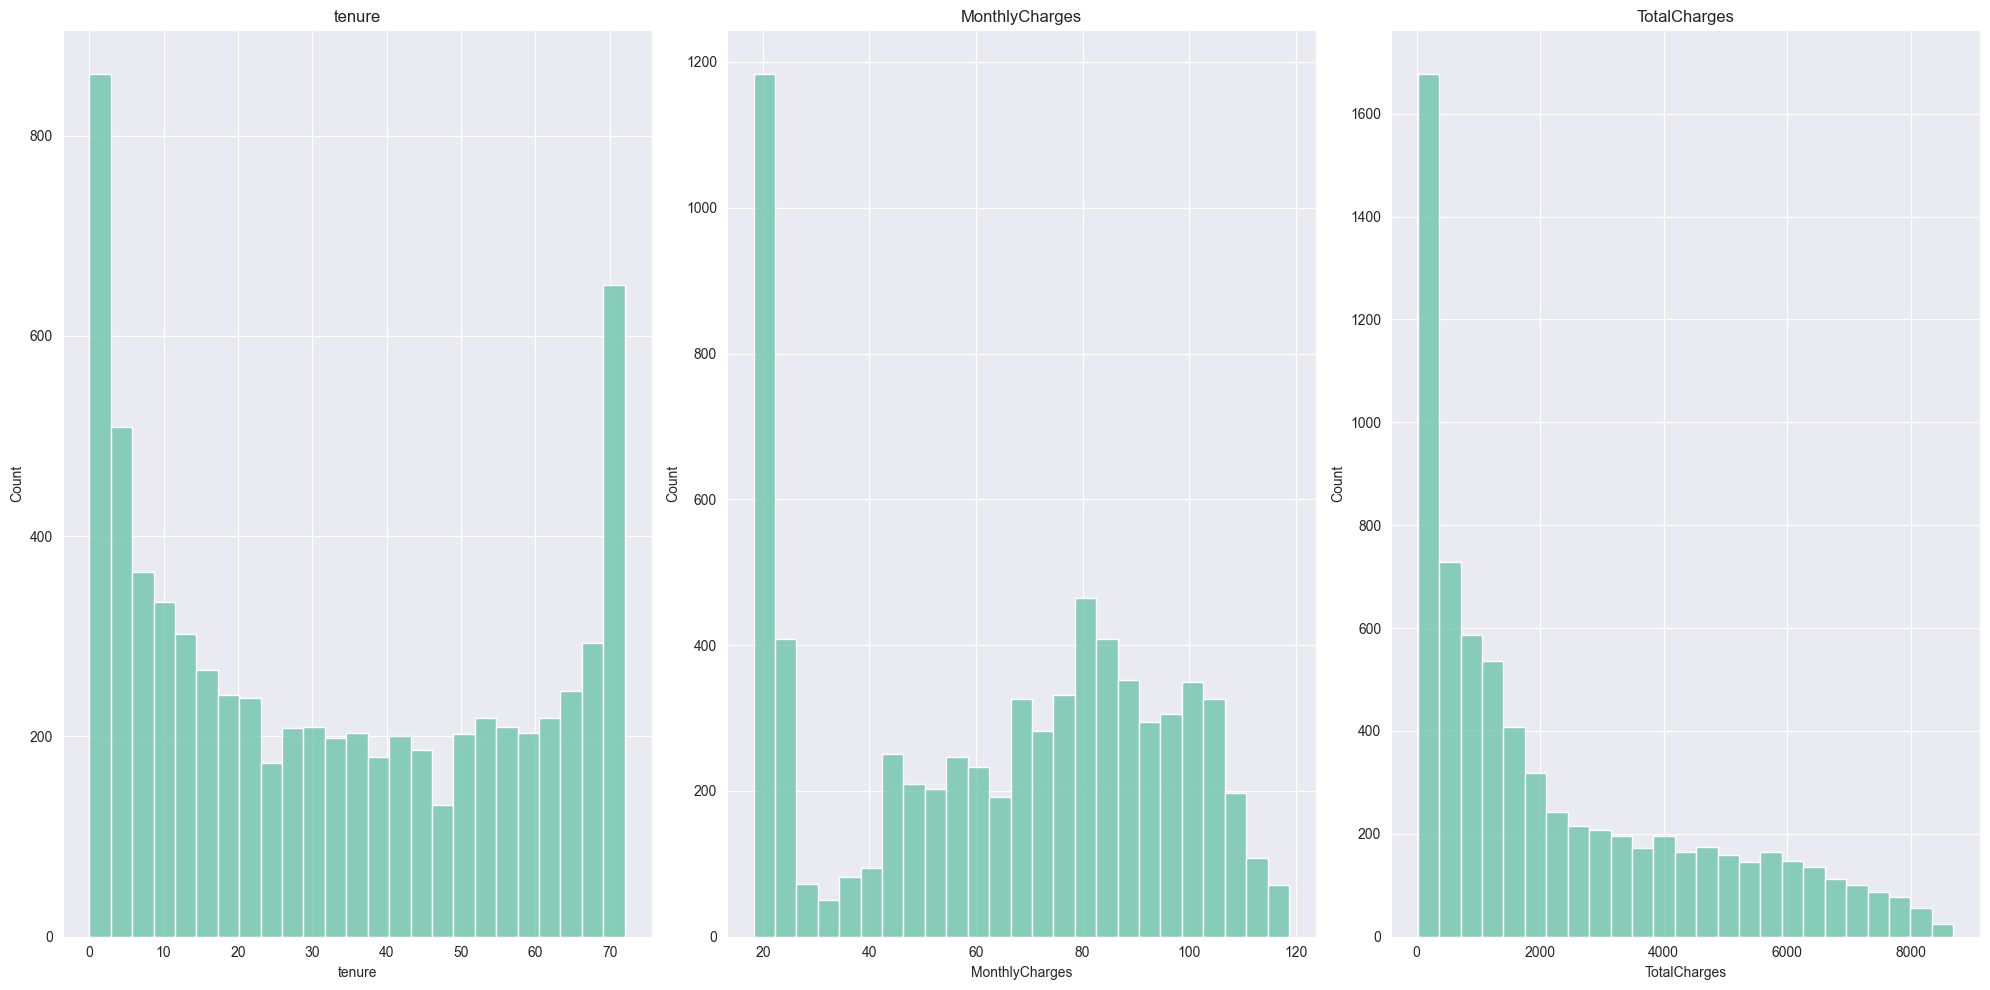

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))
axes = axes.flatten()
for i, column in enumerate(numerical_columns):
    sns.histplot(data=df,
                 x=column,
                 bins=25,
                 ax=axes[i],
                 kde=False
                 )
    axes[i].set_title(column)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(column)
plt.tight_layout()
plt.show()

In [11]:
df.describe()

tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7032.000000
mean     32.371149       64.761692   2283.300441
std      24.559481       30.090047   2266.771362
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3794.737500
max      72.000000      118.750000   8684.800000

<div style="font-family: 'Times New Roman'; font-size: 16px;">

**1.Tenure** time that client was with company:
- mean is 32 month ~ 2.7 years
- min is 1 month and max is 72 month
- std is 24 month

**2.Monthly Charges** amount of money client paid each month
- mean is $64
- min is $18 and max is $118
- std is $30

**3.Total Charges** total amount of money client paid
- mean is $2283 
- min is $18 and max is $8684
- std is $2266

we can see that total charges is related to tenure and monthly charges
</div>

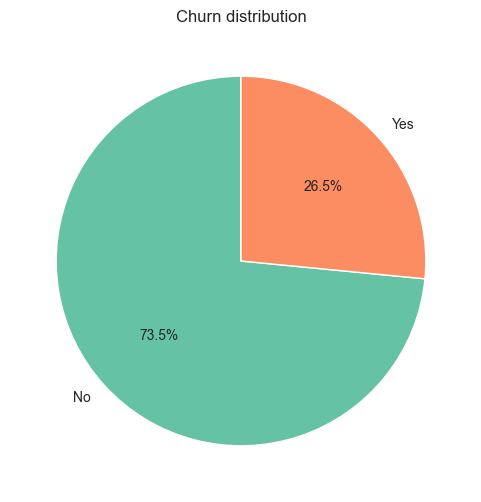

In [12]:
churn_counts = df['Churn'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Churn distribution')
plt.show()

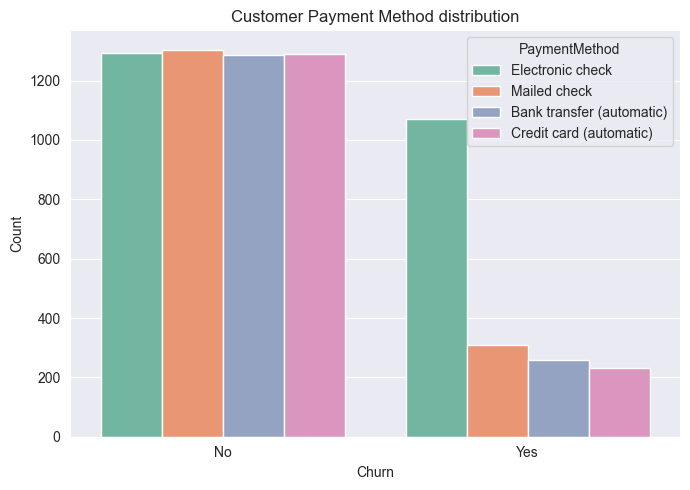

In [13]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="Churn", hue="PaymentMethod")
plt.title("Customer Payment Method distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

those who pay by electronic check are most likely to churn

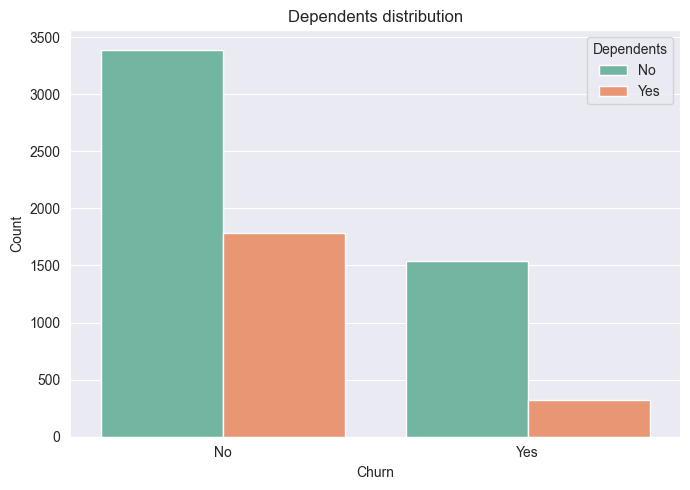

In [14]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="Churn", hue="Dependents")
plt.title("Dependents distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

those who are without dependents are most likely to churn

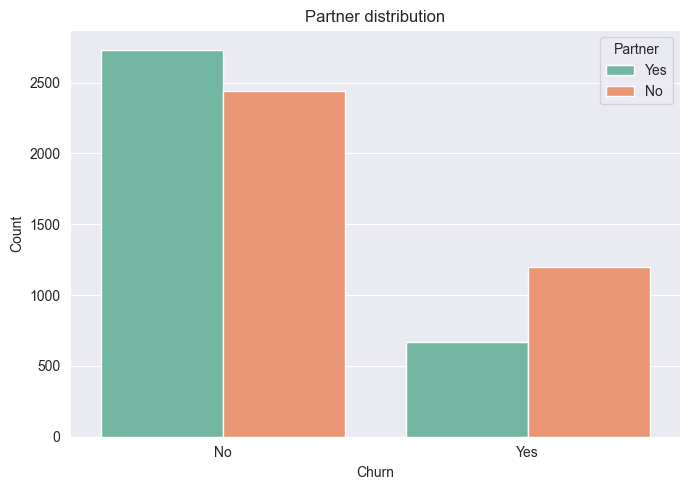

In [15]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="Churn", hue="Partner")
plt.title("Partner distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

those who have partners are most likely to churn

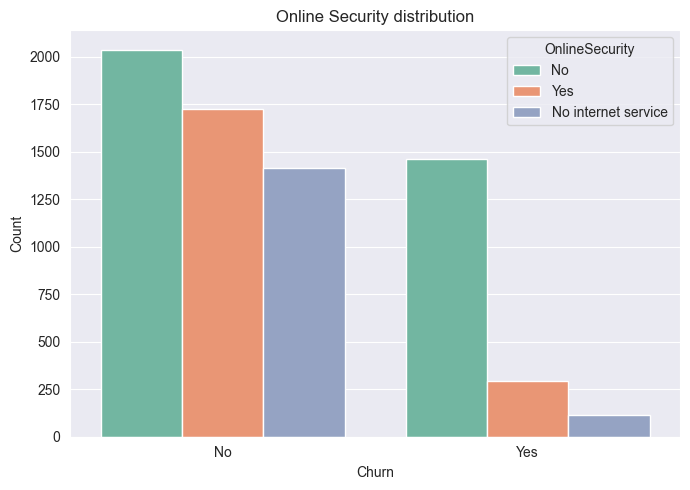

In [16]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="Churn", hue="OnlineSecurity")
plt.title("Online Security distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

those who dont have online security are most likely to churn

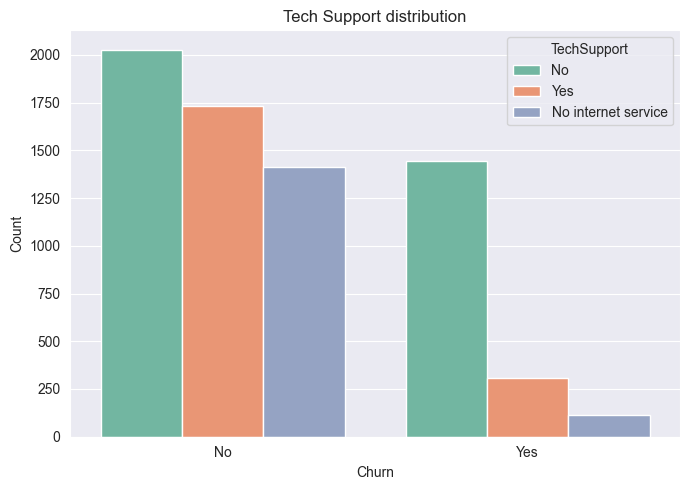

In [17]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="Churn", hue="TechSupport")
plt.title("Tech Support distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

those who have no tech support are most likely to churn

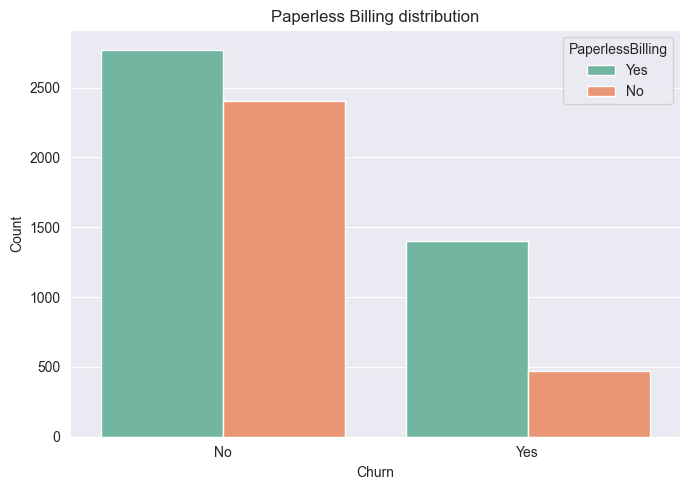

In [18]:
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x="Churn", hue="PaperlessBilling")
plt.title("Paperless Billing distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

> those with paperless billing are most likely to churn

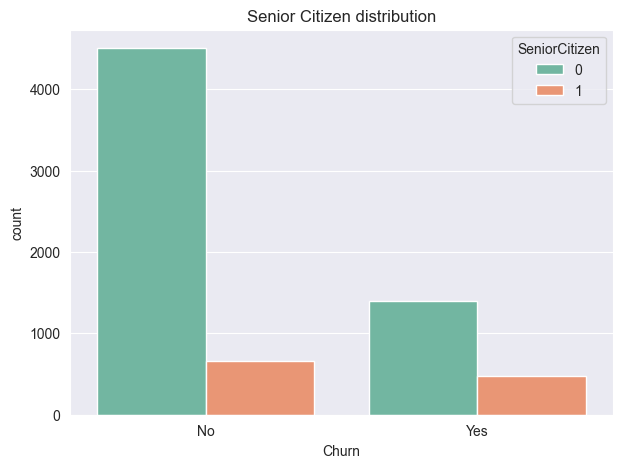

In [19]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='Churn', hue='SeniorCitizen')
plt.title("Senior Citizen distribution")
plt.show()

> senior citizens most likely to churn

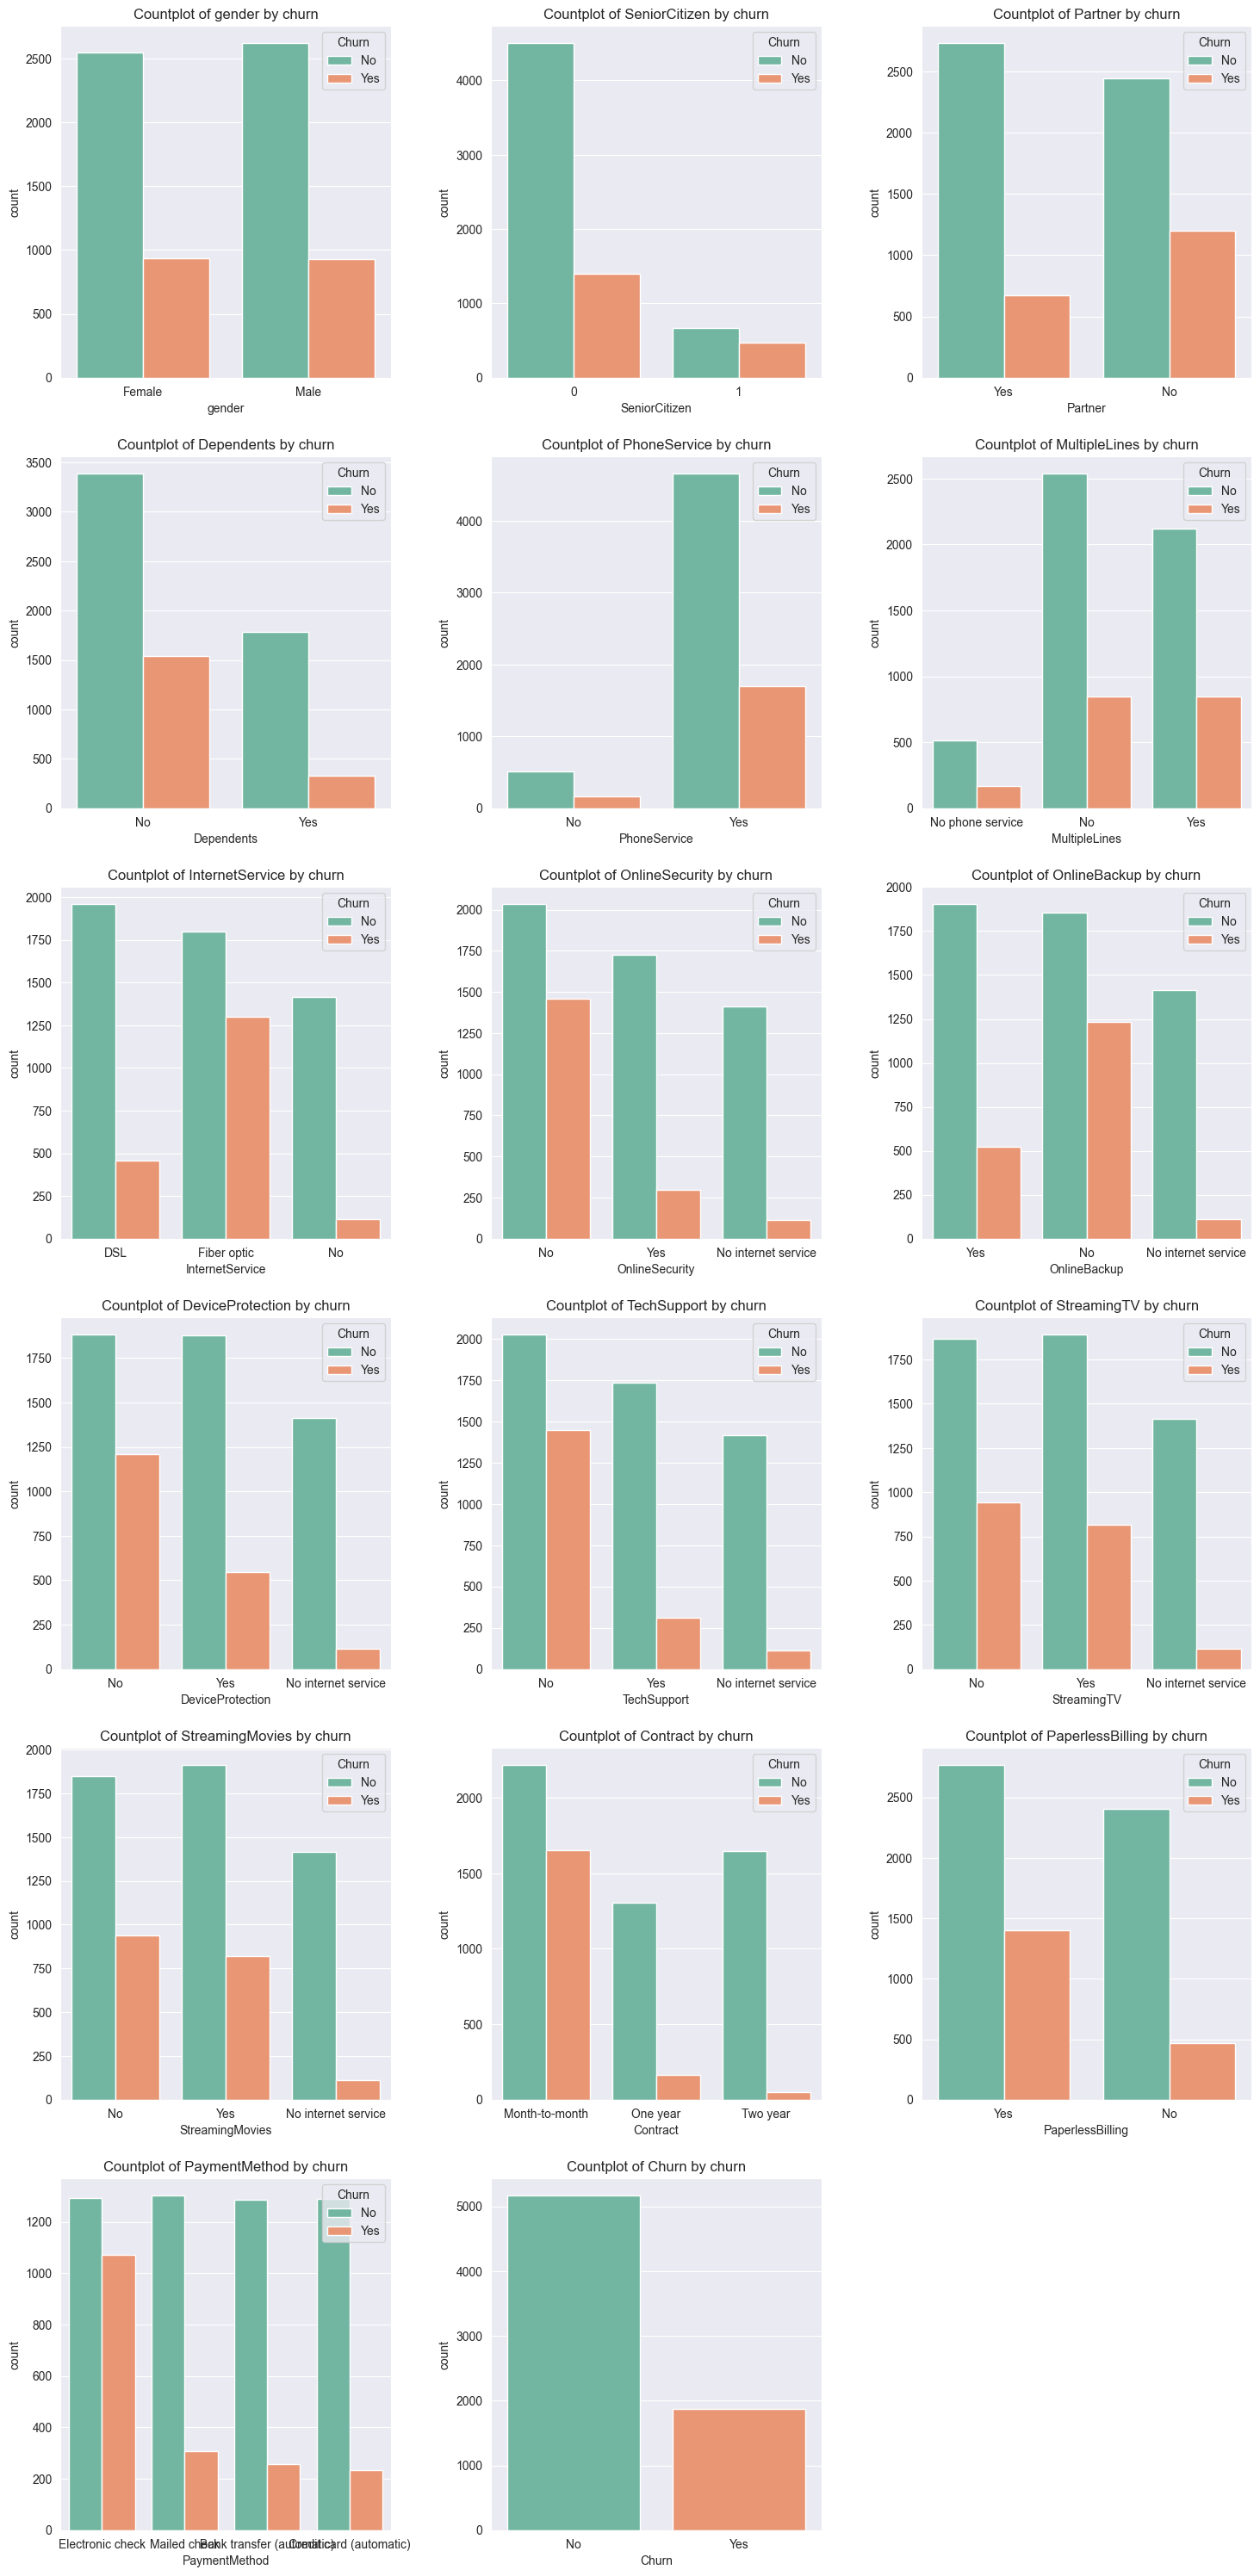

In [20]:
categorical_columns = df.select_dtypes(include=['object'])
cols = 3 # charts per row
rows = math.ceil(len(categorical_columns) / cols)

plt.figure(figsize=(5 * cols, 5 * rows))

for i, col in enumerate(categorical_columns):
    plt.subplot(rows, cols, i+1)
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Countplot of {col} by churn')
plt.tight_layout(pad=2)
plt.show()

In [21]:
for column in categorical_columns:
    print(f"{column} values: {df[column].unique()}")

gender values: ['Female' 'Male']
SeniorCitizen values: [0 1]
Partner values: ['Yes' 'No']
Dependents values: ['No' 'Yes']
PhoneService values: ['No' 'Yes']
MultipleLines values: ['No phone service' 'No' 'Yes']
InternetService values: ['DSL' 'Fiber optic' 'No']
OnlineSecurity values: ['No' 'Yes' 'No internet service']
OnlineBackup values: ['Yes' 'No' 'No internet service']
DeviceProtection values: ['No' 'Yes' 'No internet service']
TechSupport values: ['No' 'Yes' 'No internet service']
StreamingTV values: ['No' 'Yes' 'No internet service']
StreamingMovies values: ['No' 'Yes' 'No internet service']
Contract values: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling values: ['Yes' 'No']
PaymentMethod values: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn values: ['No' 'Yes']


In [22]:
df['SeniorCitizen'] = df['SeniorCitizen'].map({1.0:'Yes', 0.0:'No'})
binary_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
ohe_columns = ['InternetService', 'Contract', 'PaymentMethod']

In [23]:
#one hot encoding
df = pd.get_dummies(df, columns=ohe_columns)
print(df.head())

   gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female            No     Yes         No       1           No   
1    Male            No      No         No      34          Yes   
2    Male            No      No         No       2          Yes   
3    Male            No      No         No      45           No   
4  Female            No      No         No       2          Yes   

      MultipleLines OnlineSecurity OnlineBackup DeviceProtection  ...  \
0  No phone service             No          Yes               No  ...   
1                No            Yes           No              Yes  ...   
2                No            Yes          Yes               No  ...   
3  No phone service            Yes           No              Yes  ...   
4                No             No           No               No  ...   

  InternetService_DSL InternetService_Fiber optic InternetService_No  \
0                True                       False              False   
1             

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7043 non-null   object 
 1   SeniorCitizen                            7043 non-null   object 
 2   Partner                                  7043 non-null   object 
 3   Dependents                               7043 non-null   object 
 4   tenure                                   7043 non-null   int64  
 5   PhoneService                             7043 non-null   object 
 6   MultipleLines                            7043 non-null   object 
 7   OnlineSecurity                           7043 non-null   object 
 8   OnlineBackup                             7043 non-null   object 
 9   DeviceProtection                         7043 non-null   object 
 10  TechSupport                              7043 no

In [25]:
#encode binary columns
for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0, 'No phone service': 0, 'No internet service': 0})

In [26]:
df.rename(columns={
    'InternetService_DSL': 'DSL',
    'InternetService_Fiber optic': 'Fiber',
    'InternetService_No': 'NoInternet',
    'Contract_Month-to-month': 'Contract_Monthly',
    'Contract_One year': 'Contract_1yr',
    'Contract_Two year': 'Contract_2yr',
    'PaymentMethod_Bank transfer (automatic)': 'Pay_BankTransfer',
    'PaymentMethod_Credit card (automatic)': 'Pay_CreditCard',
    'PaymentMethod_Electronic check': 'Pay_Electronic',
    'PaymentMethod_Mailed check': 'Pay_Mailed'
}, inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   OnlineSecurity    7043 non-null   int64  
 8   OnlineBackup      7043 non-null   int64  
 9   DeviceProtection  7043 non-null   int64  
 10  TechSupport       7043 non-null   int64  
 11  StreamingTV       7043 non-null   int64  
 12  StreamingMovies   7043 non-null   int64  
 13  PaperlessBilling  7043 non-null   int64  
 14  MonthlyCharges    7043 non-null   float64
 15  TotalCharges      7032 non-null   float64
 16  Churn             7043 non-null   int64  


In [28]:
print(df.select_dtypes(include="object").columns)
print(df.isnull().sum())


Index([], dtype='object')
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
PaperlessBilling     0
MonthlyCharges       0
TotalCharges        11
Churn                0
DSL                  0
Fiber                0
NoInternet           0
Contract_Monthly     0
Contract_1yr         0
Contract_2yr         0
Pay_BankTransfer     0
Pay_CreditCard       0
Pay_Electronic       0
Pay_Mailed           0
dtype: int64


In [29]:
df.dropna(inplace=True)

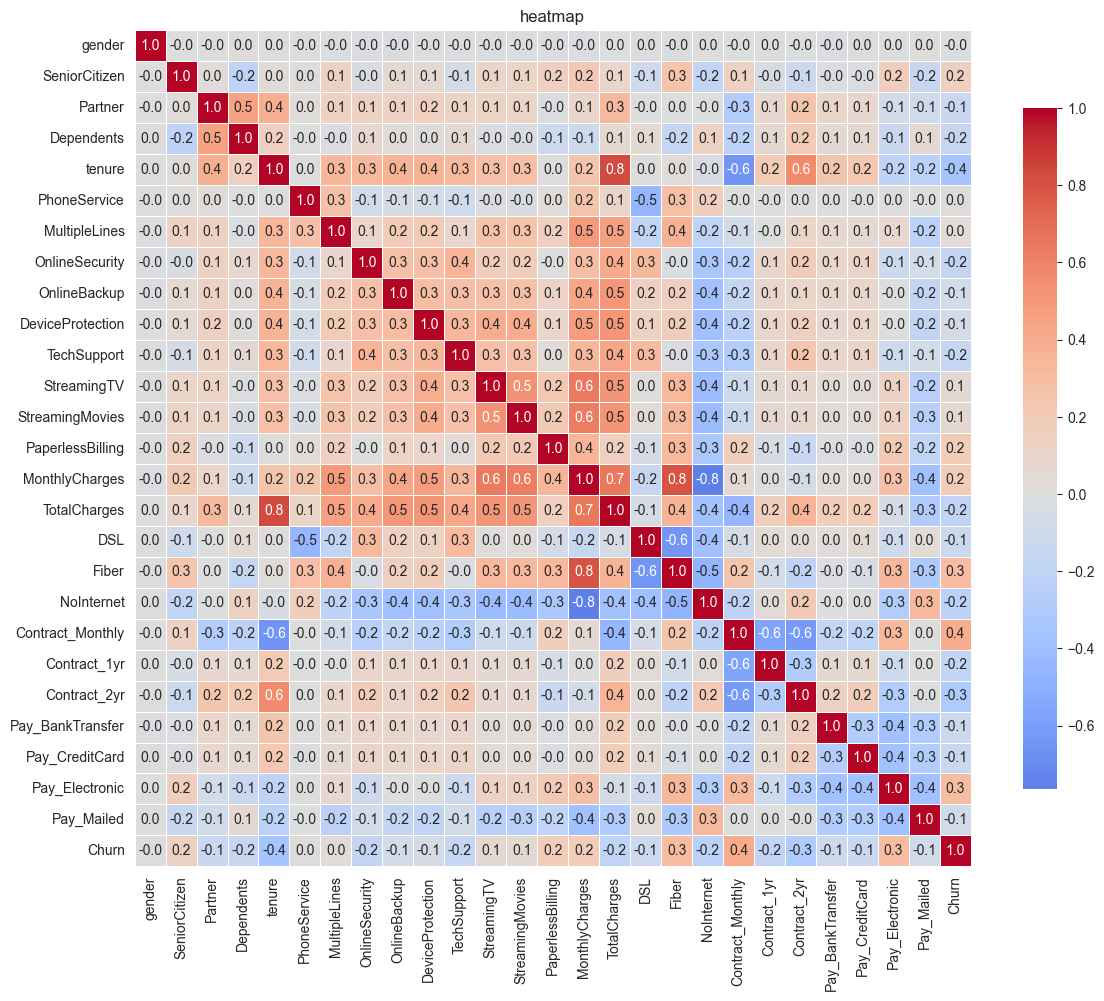

In [30]:
x = df.drop('Churn', axis=1)
y = df['Churn']

corr_matrix = x.copy()
corr_matrix['Churn'] = y
corr = corr_matrix.corr()

plt.figure(figsize=(12,10))

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt='.1f',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': .8}
)
plt.title('heatmap')
plt.tight_layout()
plt.show()

In [31]:
churn_corr = corr['Churn'].drop('Churn').sort_values(ascending=False)
print(churn_corr)

Contract_Monthly    0.404565
Fiber               0.307463
Pay_Electronic      0.301455
MonthlyCharges      0.192858
PaperlessBilling    0.191454
SeniorCitizen       0.150541
StreamingTV         0.063254
StreamingMovies     0.060860
MultipleLines       0.040033
PhoneService        0.011691
gender             -0.008545
DeviceProtection   -0.066193
OnlineBackup       -0.082307
Pay_Mailed         -0.090773
Pay_BankTransfer   -0.118136
DSL                -0.124141
Pay_CreditCard     -0.134687
Partner            -0.149982
Dependents         -0.163128
TechSupport        -0.164716
OnlineSecurity     -0.171270
Contract_1yr       -0.178225
TotalCharges       -0.199484
NoInternet         -0.227578
Contract_2yr       -0.301552
tenure             -0.354049
Name: Churn, dtype: float64


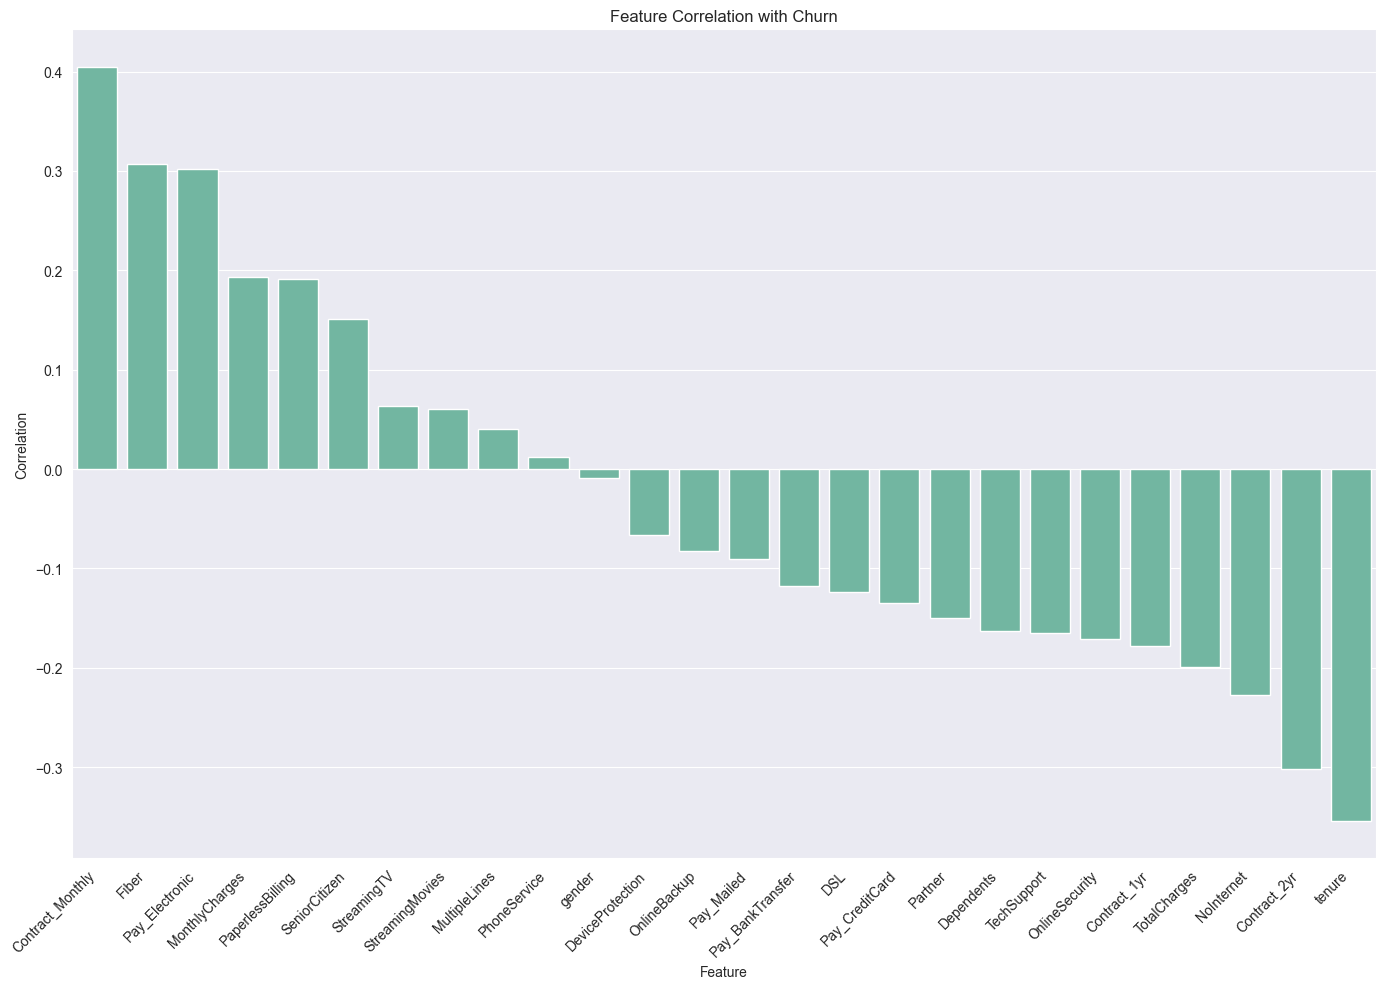

In [32]:
fig = plt.figure(figsize=(14,10))
sns.barplot(
    x=churn_corr.index,
    y=churn_corr.values,
)
plt.title("Feature Correlation with Churn")
plt.ylabel("Correlation")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<style>
    * {
        font-family: "Times New Roman", Times, serif;
        font-size: 16px;
    }
</style>
# Churn correlation analysis
## Understanding correlation: 
- **Positive correlation** with churn: customer is more likely to churn
- **Negative correlation** with churn: customer is less likely to churn

---

## Top Positive correlations
| Feature | Corellation | Interpretation |
|---------|-------------|----------------|
|Contract_monthly|+0.4|monthly contract is easier to churn|
|Fiber|+0.31|speed or price is unsatisfying|
|Pay_electronic|+0.3|it has more friction to pay with e-check, maybe they forgot and churn or being lazy and churn|

## Top Negative correlations
| Feature | Corellation | Interpretation |
|---------|-------------|----------------|
|tenure|-.37|longer customer stays, the less likely to churn|
|Contract_2year|-0.3|long term contract signifies trust and less likely to churn|
|NoInternet|-0.22|People are not bothered with internet and paying good price are less likely to churn|

## Derived strategies
- **High Risk Users**
    - who has monthly contract
    - who has higher type of internet
    - who pays with frictionful payment type
    - who hjas streaming
- **Less Risk Users**
    - who is staying long
    - who has long contract
    - who has no internet
    - who pays with traditional methods

---

In [33]:
df_copy = df.copy()
#define tenure bins
bins = [0, 12, 24, 60, np.inf]
labels = ['New', 'At-risk', 'Loyal', 'Very Loyal']
df_copy['TenureGroup'] = pd.cut(df_copy['tenure'], bins=bins, labels=labels) 

#avoid division by zero
df_copy['TotalCharges'] = pd.to_numeric(df_copy['TotalCharges'], errors='coerce')
df_copy['SpendPerMonth'] = df_copy['TotalCharges'] / df_copy['tenure']
df_copy['SpendPerMonth'].fillna(0, inplace=True)

/var/folders/bc/jgqfymlj25b557vc62ph2xrc0000gn/T/ipykernel_85324/1827261752.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['SpendPerMonth'].fillna(0, inplace=True)


In [34]:
df_copy.head()

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0              0               0             1                 0  ...   
1              0               1             0                 1  ...   
2              0               1             1                 0  ...   
3              0               1             0                 1  ...   
4              0               0             0                 0  ...   

   NoInternet  Contract_Monthly  Contract_1yr  Contract_2yr  Pay_BankTransfer  \
0       False              True         False         False             False   
1       False             False          True         False             False   
2       False              True         False         False             False   
3       False             False          True         False              True   
4       False              True         False         False             False   

   Pay_CreditCard  Pay_Electronic  Pay_Mailed  TenureGroup  SpendPerMonth  
0           False            True       False          New      29.850000  
1           False           False        True        Loyal      55.573529  
2           False           False        True          New      54.075000  
3           False           False       False        Loyal      40.905556  
4           False            True       False          New      75.825000  

[5 rows x 29 columns]

In [35]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

<h1>Part 2: Model evaluation and interpretation</h1>

<p style="font-size: 18px; font-family: 'Times New Roman';"> in this section we will see which models work best with out dataset and see how we can reinforce it through understand the correlations and evaluating metrics like accuracy, precision, f1-score, recall, ROC-AUC

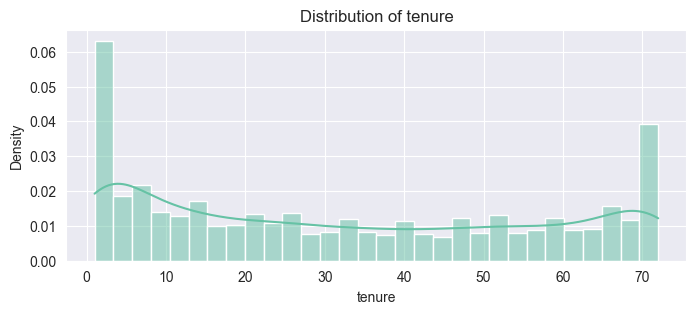

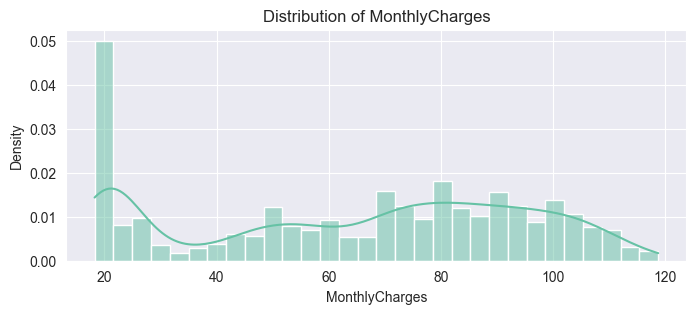

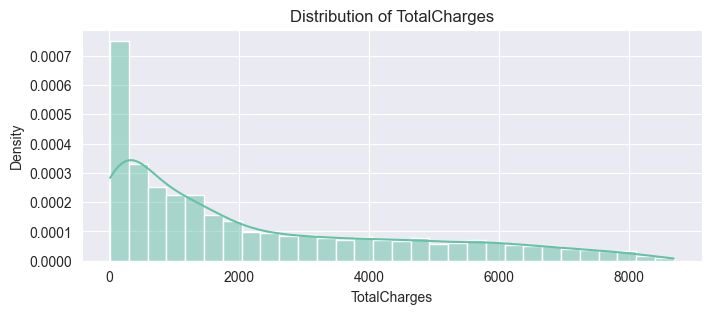

In [37]:
def distplot(frame, column):
    plt.figure(figsize=(8,3))
    plt.title(f"Distribution of {column}")
    fig = sns.histplot(frame[column], kde=True, stat='density', bins=30)
    plt.show()
for col in numerical_columns:
    distplot(df_copy, col)

In [38]:
num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
dataset_std = pd.DataFrame(StandardScaler().fit_transform(df_copy[num_cols].astype('float64')), columns=num_cols)
dataset_std.info()

cat_cols_ohe = ['PaymentMethod', 'Contract', 'InternetService']
cat_cols_le = list(set(X_train.columns) - set(num_cols) - set(cat_cols_ohe))

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7032 non-null   float64
 1   MonthlyCharges  7032 non-null   float64
 2   TotalCharges    7032 non-null   float64
dtypes: float64(3)
memory usage: 164.9 KB


### Logistic regression model training

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5625 entries, 6030 to 862
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5625 non-null   int64  
 1   SeniorCitizen     5625 non-null   int64  
 2   Partner           5625 non-null   int64  
 3   Dependents        5625 non-null   int64  
 4   tenure            5625 non-null   float64
 5   PhoneService      5625 non-null   int64  
 6   MultipleLines     5625 non-null   int64  
 7   OnlineSecurity    5625 non-null   int64  
 8   OnlineBackup      5625 non-null   int64  
 9   DeviceProtection  5625 non-null   int64  
 10  TechSupport       5625 non-null   int64  
 11  StreamingTV       5625 non-null   int64  
 12  StreamingMovies   5625 non-null   int64  
 13  PaperlessBilling  5625 non-null   int64  
 14  MonthlyCharges    5625 non-null   float64
 15  TotalCharges      5625 non-null   float64
 16  DSL               5625 non-null   bool   
 17

In [40]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2']
}

logreg = LogisticRegression(random_state=42, max_iter=1000)
grid_search_cv = GridSearchCV(logreg, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search_cv.fit(X_train, y_train)

best_logreg = grid_search_cv.best_estimator_
print(f"Best params for logreg: {grid_search_cv.best_params_}")

Best params for logreg: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [41]:
y_pred = best_logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_logreg.predict_proba(X_test)[:, 1])


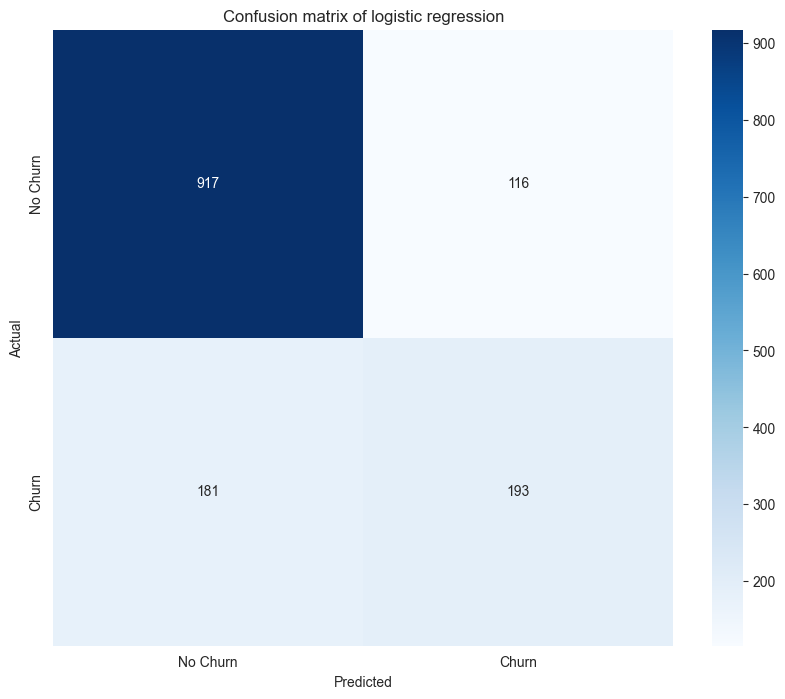

In [42]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion matrix of logistic regression')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

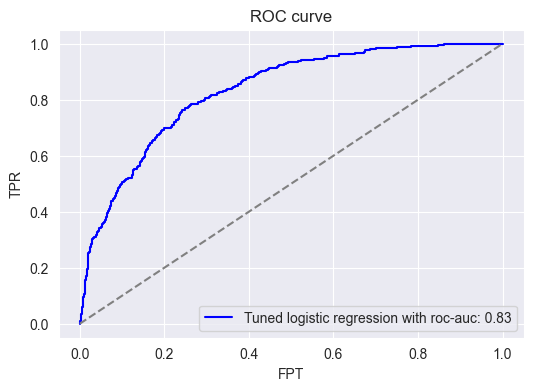

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, best_logreg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'Tuned logistic regression with roc-auc: {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPT')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [44]:
print(accuracy)
print(class_report)
print(roc_auc)

0.7889125799573561
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.62      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

0.8317009281931553


In [45]:
feature_names = X_train.columns
coefs = best_logreg.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coef': coefs
})
coef_df['Coef'] = coef_df['Coef'].abs()
coef_df = coef_df.sort_values(by='Coef', ascending=False)
print(coef_df)

             Feature      Coef
18        NoInternet  2.864617
14    MonthlyCharges  1.727042
4             tenure  1.509555
17             Fiber  1.498123
21      Contract_2yr  1.330923
12   StreamingMovies  0.813260
11       StreamingTV  0.793520
15      TotalCharges  0.760637
20      Contract_1yr  0.757122
16               DSL  0.708833
23    Pay_CreditCard  0.671716
25        Pay_Mailed  0.602025
22  Pay_BankTransfer  0.530770
5       PhoneService  0.509163
6      MultipleLines  0.505700
13  PaperlessBilling  0.272495
24    Pay_Electronic  0.270815
9   DeviceProtection  0.260650
1      SeniorCitizen  0.259583
3         Dependents  0.215584
7     OnlineSecurity  0.166009
8       OnlineBackup  0.158165
10       TechSupport  0.137204
2            Partner  0.050434
0             gender  0.030343
19  Contract_Monthly  0.012719


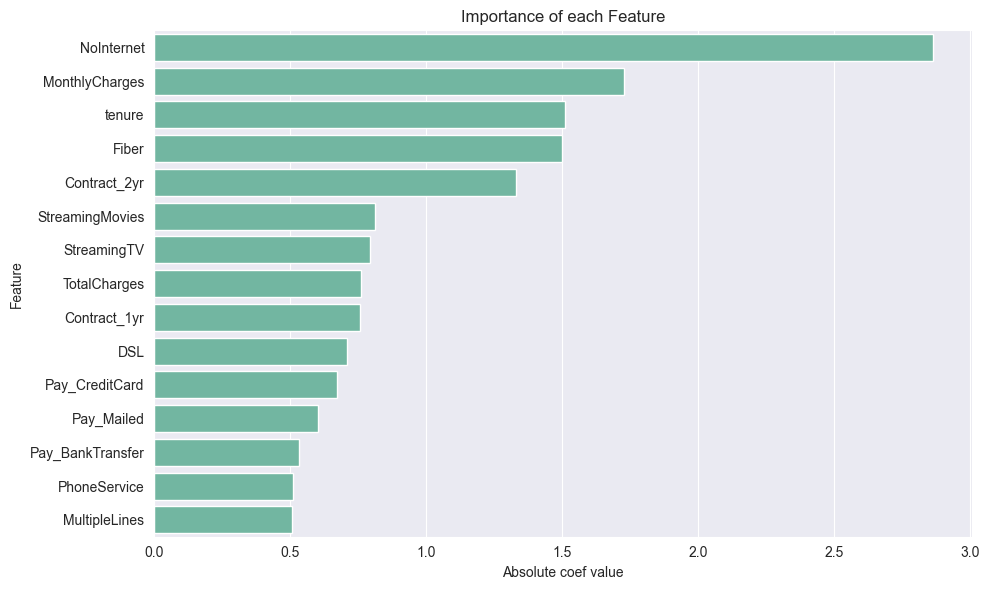

In [46]:
plt.figure(figsize=(10,6))
sns.barplot(coef_df.head(15), x='Coef', y='Feature')
plt.title('Importance of each Feature')
plt.xlabel('Absolute coef value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [47]:
display(coef_df.head(15))

Feature      Coef
18        NoInternet  2.864617
14    MonthlyCharges  1.727042
4             tenure  1.509555
17             Fiber  1.498123
21      Contract_2yr  1.330923
12   StreamingMovies  0.813260
11       StreamingTV  0.793520
15      TotalCharges  0.760637
20      Contract_1yr  0.757122
16               DSL  0.708833
23    Pay_CreditCard  0.671716
25        Pay_Mailed  0.602025
22  Pay_BankTransfer  0.530770
5       PhoneService  0.509163
6      MultipleLines  0.505700

In [49]:
param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500]
}

lgbm = LGBMClassifier(random_state=42)

grid_search_lgbm = GridSearchCV(lgbm, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

best_lgbm = grid_search_lgbm.best_estimator_
print("Best LGBM parameters:", grid_search_lgbm.best_params_)

[LightGBM] [Info] Number of positive: 1196, number of negative: 3304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
[LightGBM] [Info] Number of positive: 1196, number of negative: 3304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM]

In [50]:
y_pred_lgbm = best_lgbm.predict(X_test)
y_pred_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
class_report_lgbm = classification_report(y_test, y_pred_lgbm)

In [51]:
print('Logreg results:')
print(accuracy)
print(class_report)
print(roc_auc)
print('LGBM results')
print(accuracy_lgbm)
print(class_report_lgbm)
print(roc_auc_lgbm)

Logreg results:
0.7889125799573561
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.62      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

0.8317009281931553
LGBM results
0.7938877043354655
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.65      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

0.8319494126965228


/Users/zhantore/Library/Python/3.10/lib/python/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


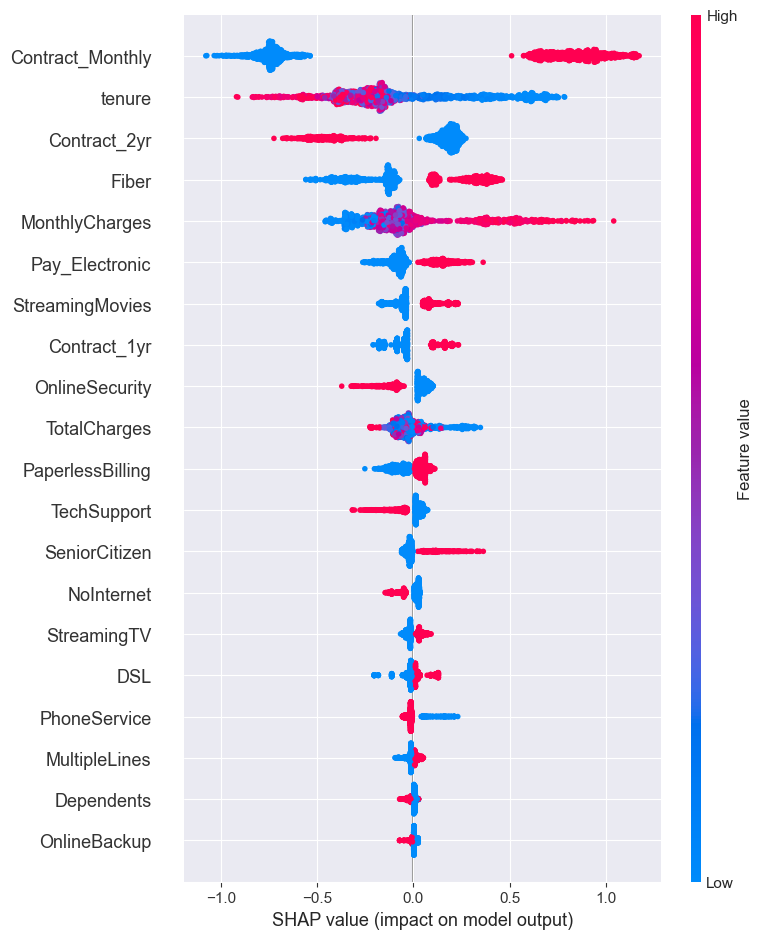

In [55]:
explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)